# Analysis Summary

This notebook provides answers to questions about the open-coding analysis process itself.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from IPython.display import display, Markdown
from lib.util import getCodes

%autosave 0

Autosave disabled


Import all codes from the open coding process

In [2]:
%%time
codes = getCodes()

CPU times: user 49.2 s, sys: 100 ms, total: 49.3 s
Wall time: 49.7 s


Parse works cited section of the `README.md` document for more analysis information.

In [127]:
# See regular expression at regexr.com/4htcn
regxp = r'\n([^\n\.\#]+)\.\s\((\d{4}),\s(\w+)\s(\d+)\)\.\s([^\.]+\.)\s\*([^\*]+)\*\.\sRetrieved from https:\/\/(?:[^\/]+\/){2}(.*)\n'
with open('README.md') as readme:
    content = readme.read()

citations = re.findall(regxp,content)
citations = pd.DataFrame(citations, columns=['journalist', 'year', 'month', 'date', 'article', 'organization', 'path'])

citations.replace(to_replace=r'data/tree/master/|data-projects/tree/master/|2016/05/|st-methods/tree/master/', 
                  value='', 
                  regex=True, 
                  inplace=True)

citations.head()

,journalist,year,month,date,article,organization,path
0,"Aldhous, Peter",2016,September,16,"""Shy Trumpers"" polling analysis.",BuzzFeed News,2016-09-shy-trumpers
1,"Arthur, Rob",2015,July,30,Buster Posey MVP.,FiveThirtyEight,buster-posey-mvp
2,"Bi, Frank",2016,Jan,13,Uber launch cities and date.,Vox,verge-uber-launch-dates
3,"Bradshaw, Paul",2019,April,6,Lack of electric car charging points 'putting ...,BBC,electric-car-charging-points
4,"Bradshaw, Paul",2019,March,8,Birmingham remains top destination for Londoners.,BBC,internal-migration-london


## Analysis by the numbers

In [128]:
byTheNumbers = citations.loc[:,['journalist', 'organization', 'article']].describe().loc['unique',:].to_frame('count')
byTheNumbers = byTheNumbers.append(pd.DataFrame({
        'count': [ codes.code.nunique(), 
                   repos.shape[0],
                   keepers.shape[0],
                   keepers.org.nunique(),
                 ],
    }, index=['codes', 'repos', 'relevant repos', 'total organizations']))

byTheNumbers

,count
journalist,30
organization,25
article,46
codes,148
repos,1295
relevant repos,225
total organizations,50


## Progress towards convergence

The works cited page of analyzed computational notebooks serves as a list of coded notebooks, but it doesn't preserve the order in which they were coded. The `reposIncluded` list has lists each repo in reverse chronological order.

In [129]:
pathsIncluded = [
    'swana-population-map',
    '1805-regionen im fokus des US-praesidenten',
    'school-choice',
    '201901-achievementgap',
    'general-election-2015-classification-tree',
    '201901-hospitalquality',
    'awb-notebook',
    'skatemusic',
    'new-york-schools-assessment',
    'lending-club',
    'auditData',
    '2019-ems-analysis',
    '2018-voter-registration',
    'federal_employees_trump_2017', 
    'infrastructure-jobs',
    'librarians',
    'midwife-led-units',
    'internal-migration-london',
    'electric-car-charging-points',
    'school-star-ratings-2018',
    'prison-admissions',
    'vox-central-line-infections',
    'verge-uber-launch-dates',
    'buster-posey-mvp',
    'work-from-home',
    'nyc-trips',
    'bob-ross',
    'bechdel',
    'employment-discrimination',
    '2015-11-refugees-in-the-united-states',
    'babyname_politics',
    'wikipedia-rankings',
    'Power_of_Irma',
    'Endangered-Species-Act-Louisiana',
    'california-h2a-visas-analysis',
    '2016-04-republican-donor-movements',
    'the-cube-root-law',
    '2016-09-shy-trumpers',
    '2018-05-31-crime-and-heat-analysis',
    '2016-11-bellwether-counties',
    'heat-index',
    '2018-voter-registration',
    'long-term-care-db',
    'census-hard-to-map-analysis',
    'california-crop-production-wages-analysis',
    'california-ccscore-analysis',
    '2019-04-democratic-candidate-codonors',
]

codingOrder = pd.DataFrame({'article': pathsIncluded[::-1] }).reset_index().rename(columns={'index': 'coding order'})

### Sanity Check

Make sure that I've manually added all the repos to `reposIncluded` that are listed in `README.md`.

In [130]:
citMinusPath = set(citations.path.unique()).difference(set(pathsIncluded))
pathMinusCit = set(pathsIncluded).difference(set(citations.path.unique()))

if len(citMinusPath) > 0:
    display(Markdown('In `citations` but not in `pathsIncluded`: {}'.format(', '.join(list(citMinusPath)))))
else:
    display(Markdown('All paths in `citations` are also in `pathsIncluded`\n'))

if len(pathMinusCit) > 0:
    display(Markdown('In `pathsIncluded` but not in `citations`: {}'.format(', '.join(list(pathMinusCit)))))
else:
    display(Markdown('All paths in `pathsIncluded` are also in `citations`\n'))

All paths in `citations` are also in `pathsIncluded`


All paths in `pathsIncluded` are also in `citations`


Also get the list of data journalism repos identified in `find_notebooks.ipynb`. 

In [131]:
repos = pd.read_csv('potential_notebooks.csv')
keepers = repos[repos.is_keeper == True]

Create a data frame of codes grouped by article.

In [132]:
codesByArticle = codes.groupby(['article']).code \
    .unique() \
    .to_frame('codes') \
    .reset_index() \
    .merge(codingOrder, on='article') \
    .sort_values('coding order') \
    .reset_index()

codesByArticle['cumulative count'] = 0

codeset = set()
for i, row in codesByArticle.iterrows():
    setDiff = set(row.codes).difference(codeset)
    codeset = codeset.union(setDiff)
    codesByArticle.loc[i, 'cumulative count'] = len(codeset)
    codesByArticle.loc[i, 'new codes'] = ', '.join(setDiff)

codesByArticle

,index,article,codes,coding order,cumulative count,new codes
0,8,2019-04-democratic-candidate-codonors,"[use open government data, read as tabular dat...",0,28,"subset columns, canonicalize column names, use..."
1,19,california-crop-production-wages-analysis,"[use open government data, format table displa...",2,42,"trim by geographic area, wrangle data for grap..."
2,21,census-hard-to-map-analysis,"[wrangle data for graphics, use open governmen...",3,44,"tolerate dirty data, slice column values"
3,30,long-term-care-db,"[count value frequency, calculate scaled ratio...",4,56,"construct pivot table, perform entity resoluti..."
4,6,2018-voter-registration,"[pull tables out of pdf, annotate workflow, ch...",5,60,"calculate a statistic, create rolling window, ..."
5,26,heat-index,"[wrangle data for graphics, compute index numb...",6,63,"cartesian product, generate data computational..."
6,4,2016-11-bellwether-counties,"[use academic data, remove incomplete data, un...",7,68,"use academic data, remove incomplete data, get..."
7,5,2018-05-31-crime-and-heat-analysis,"[combine seemingly disparate datasets, use ope...",8,71,"combine seemingly disparate datasets, extract ..."
8,3,2016-09-shy-trumpers,"[answer a question, read as tabular data, use ...",9,72,use another news orgs data
9,39,the-cube-root-law,"[read as tabular data, subset columns, change ...",10,74,"wtf, use public data"


Plot the size of the code set as more computational notebooks are analyzed.

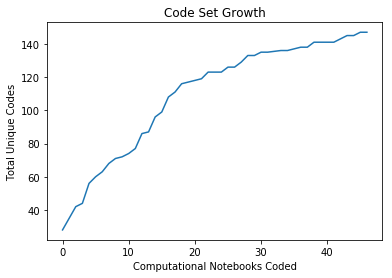

In [133]:
ax = sns.lineplot(x='coding order', y='cumulative count', markers=True, dashes=False, data=codesByArticle)
ax.set(xlabel='Computational Notebooks Coded', ylabel='Total Unique Codes', title='Code Set Growth')
plt.show()

Map codes back to the article where they were introduced to the code set.

In [76]:
for i, row in codesByArticle.iterrows():
    display(Markdown('{}. **{}**: {}'.format(i + 1, row.article, row['new codes'])))

1. **2019-04-democratic-candidate-codonors**: subset columns, canonicalize column names, use open government data, group by single column, sum along dimension, outer join tables, annotate workflow, peek at data, change case, strip whitespace, sort table, architect a subroutine, count value frequency, repetitive code, create a semi-unique key, drop duplicate rows based on prior knowledge, count unique values in column, trim by contains value, remove with regular expression, calculate ratio, self join table, calculate scaled ratio, compare different groups along a common metric, group by multiple columns, export intermediate results, union tables, read as tabular data, gather table

2. **california-crop-production-wages-analysis**: trim by geographic area, wrangle data for graphics, architect repeating process, calculate mean, trim by date range, construct table manually, format table display, calculate percentage difference, visualize data, change column data type, answer a question, export results, inner join tables, adjust for inflation

3. **census-hard-to-map-analysis**: tolerate dirty data, slice column values

4. **long-term-care-db**: construct pivot table, perform entity resolution manually, use non-public, provided data, encode table identification in row, scrape web for data, drop duplicate rows based on values, fill in na values after an outer join, refine table, aggregate the forest from the trees, drop erroneous rows, fix data errors manually, join with lookup table

5. **2018-voter-registration**: calculate a statistic, create rolling window, pull tables out of pdf, show trend over time

6. **heat-index**: cartesian product, generate data computationally, compute index number

7. **2016-11-bellwether-counties**: use academic data, remove incomplete data, get extreme values, spread table, calculate difference

8. **2018-05-31-crime-and-heat-analysis**: combine seemingly disparate datasets, extract property from datetime, split, compute, and merge

9. **2016-09-shy-trumpers**: use another news orgs data

10. **the-cube-root-law**: wtf, use public data

11. **2016-04-republican-donor-movements**: split column on delimiter, explore dynamic network flow, trim by quantitative threshold

12. **california-h2a-visas-analysis**: preserve existing values, temporary joining column, create child table, replace na values, create a crosstab, cache results from external service, geocode addresses, create a unique key, split and compute

13. **Endangered-Species-Act-Louisiana**: transform vector

14. **Power_of_Irma**: value replacement, fix incorrect calculation, change date format, use data from colleague, interpret statistical/ml model, use previously cleaned data, toggle step on and off, outlier detection, set data confidence threshold

15. **wikipedia-rankings**: collect raw data, explain variance, calculate z-score

16. **babyname_politics**: concatenate columns into key, get unique values, data loss from aggregation, break ties, assign ranks, join aggregate, round floating point, check results of previous operation, resort after merge

17. **2015-11-refugees-in-the-united-states**: designate column as primary key, make an incorrect conclusion, test for equality

18. **employment-discrimination**: concatenate files together, align table columns for consolidation, inspect table schema, combine entities by string matching, merge tables to create pivot table

19. **nyc-trips**: full join tables

20. **work-from-home**: create flag, translate entity names manually, data too large for repo, copy table schema

21. **prison-admissions**: 

22. **school-star-ratings-2018**: pad column values, display rows with missing values, reconcile primary keys between tables

23. **electric-car-charging-points**: define edge weights, create edge, find nearest neighbours in the network, encode redundant information

24. **internal-migration-london**: 

25. **midwife-led-units**: freedom of information data, test different computations for equality

26. **federal_employees_trump_2017**: resolve to arbitrary entity name among choices

27. **2018-voter-registration**: 

28. **2019-ems-analysis**: combine data and geography

29. **auditData**: combine columns

30. **new-york-schools-assessment**: backfill missing data, create lookup table, combine drifting datasets

31. **skatemusic**: 

32. **201901-hospitalquality**: 

33. **201901-achievementgap**: bin values, query database

34. **school-choice**: 

35. **swana-population-map**: 

# Notebook Coverage

Add the repo count and commit count grouping the `repos` table created in `notebooks-search.csv`, and exported to `data/repos.csv`, by organization. Then merge the repo counts and commit counts per organization to the `citations` data frame.

In [11]:
repos = pd.read_csv('data/repos.csv')

orgs = repos[repos.is_keeper == True] \
    .groupby('org') \
    .agg({
        'url': 'nunique',
        'commits': 'sum'
    }) \
    .reset_index() \
    .rename(columns={
        'org': 'organization', 
        'url': 'repo_count',
        'commits': 'commit_count'
    })

# Assign ranks to each organization per repo count and commit count
def rank(sort_col, rank_col):
    orgs.sort_values(sort_col, ascending=False, inplace=True)
    orgs[rank_col] = orgs.reset_index().index + 1

rank('repo_count', 'repo_rank')
rank('commit_count', 'commit_rank')

# Find which organizations have been included in analysis
includedOrgs = list(citations.organization.unique())
orgs['is_included'] = False
orgs.loc[orgs.organization.isin(includedOrgs), 'is_included'] = True

orgs

,organization,repo_count,commit_count,repo_rank,commit_rank,is_included
10,FiveThirtyEight,1,899.0,30,1,True
3,Baltimore Sun,21,277.0,3,2,True
0,Austin American-Statesman,11,277.0,4,3,True
4,BuzzFeed News,81,242.0,1,4,True
34,TrendCT,4,164.0,11,5,True
13,National Public Radio,6,133.0,8,6,True
2,BBC,10,123.0,5,7,True
27,The Buffalo News,3,117.0,14,8,True
35,Vox,1,115.0,20,9,True
15,New York Times,7,106.0,6,10,True


In [12]:
display(Markdown('Analysis includes the top {lowestRepo} and {lowestCommit} organizations by repo count and commit count, respectively.'.format(**{
    'lowestRepo': orgs[orgs.is_included == False].repo_rank.min() - 1,
    'lowestCommit': orgs[orgs.is_included == False].commit_rank.min() - 1
})))

Analysis includes the top 20 and 19 organizations by repo count and commit count, respectively.